# Aerobicity phenotype: data analysis, processing, and visualization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import random
import requests

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler

import torch

from feature_selection.feature_selection_utils import (
    mutual_info_features,
    random_forest_features,
    shap_features,
    xgboost_train_accur,
    xgboost_accur_select_features,
    plot_accuracy_metric,
    make_cog_descr
)

In [3]:
# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_aerob_data, pca_run_and_plot, tsne_plot

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42

## 1. Read the dataset

In [5]:
#full data
X, y, full_data = read_aerob_data()

Read in 47894 GTDB representatives
Data without noise: 3161

Counts of y: shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 1            ┆ 2106 │
│ 0            ┆ 1055 │
└──────────────┴──────┘


In [6]:
#train
X_train, y_train, full_data_train = read_aerob_data(
    X_data_path='../data_aerob/input_data/train_data_family_tax_level', 
    y_data_path = '../data_aerob/input_data/train_annot_family_tax_level',
    bac_phylogeny_data_path='../data_preparation/gtdb_files/bac120_metadata_r202.tsv', 
    arch_phylogeny_data_path='../data_preparation/gtdb_files/ar122_metadata_r202.tsv',
    target_column = 'annotation')

# full_data_train

Read in 47894 GTDB representatives
Data without noise: 2528

Counts of y: shape: (2, 2)
┌────────────┬──────┐
│ annotation ┆ len  │
│ ---        ┆ ---  │
│ i32        ┆ u32  │
╞════════════╪══════╡
│ 1          ┆ 1662 │
│ 0          ┆ 866  │
└────────────┴──────┘


In [7]:
#test
X_test, y_test, full_data_test = read_aerob_data(
    X_data_path='../data_aerob/input_data/test_data_family_tax_level', 
    y_data_path = '../data_aerob/input_data/test_annot_family_tax_level',
    bac_phylogeny_data_path='../data_preparation/gtdb_files/bac120_metadata_r202.tsv', 
    arch_phylogeny_data_path='../data_preparation/gtdb_files/ar122_metadata_r202.tsv',
    target_column = 'annotation')

# full_data_test

Read in 47894 GTDB representatives
Data without noise: 633

Counts of y: shape: (2, 2)
┌────────────┬─────┐
│ annotation ┆ len │
│ ---        ┆ --- │
│ i32        ┆ u32 │
╞════════════╪═════╡
│ 1          ┆ 444 │
│ 0          ┆ 189 │
└────────────┴─────┘


In [8]:
X_train =  torch.tensor(X_train.values)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test)

X_train_np = np.array(X_train.cpu())
X_train_transposed = X_train_np.T

X_column_names = X.columns
n_cols = len(X_column_names)

## 2. PCA and tSNE projections

*All features*

**Colored by oxytolerance**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.00853559 0.00788752 0.00746712 0.00698056 0.00635046 0.00614104
 0.00590481 0.00526064]
Total explained variance: 0.4999673575673785
Shape of the projected data = (3161, 2)


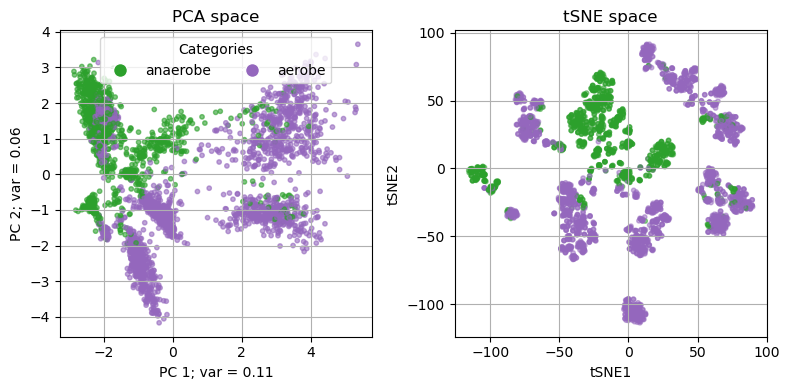

In [9]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X, n_compon, y, category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, y, colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by domain (bacteria vs archaea)**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788753 0.00746711 0.00698073 0.00635075 0.0061415
 0.00590507 0.00526048]
Total explained variance: 0.4999683806222556
Shape of the projected data = (3161, 2)


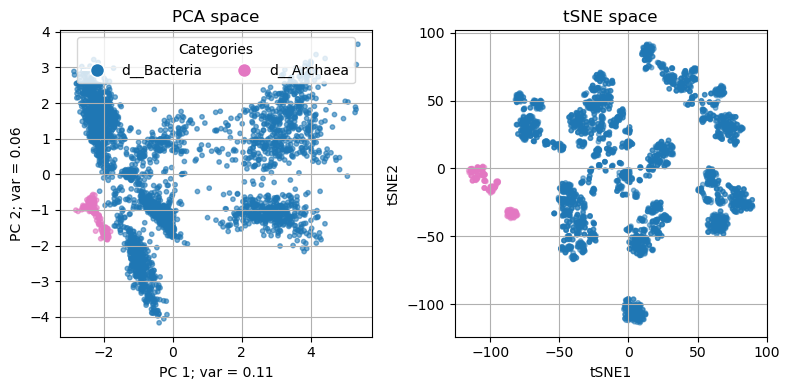

In [10]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:blue", "tab:pink"])
category_names = full_data['domain']
pca_run_and_plot(X, n_compon, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']],
                 category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']], colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by Phylum**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788753 0.00746712 0.00698071 0.00635051 0.00614153
 0.00590525 0.00526031]
Total explained variance: 0.49996816656989884
Shape of the projected data = (3161, 2)


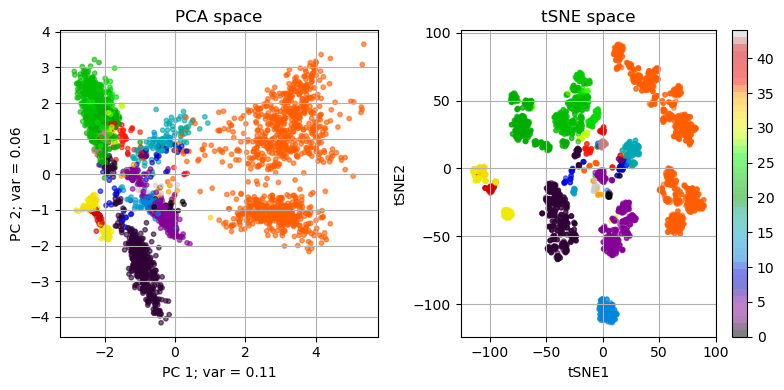

In [11]:
label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = None
category_names = full_data['phylum']
pca_run_and_plot(X, n_compon, 
                 label_encoder.fit_transform(full_data['phylum']),
                 category_names, colors);
plt.legend().remove()
# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, 
          label_encoder.fit_transform(full_data['phylum']), 
          colors);


# Display the plots
plt.legend().remove()
plt.tight_layout()  
plt.show()

## 3. XGBoost training and feature selection

In [9]:
cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_train, y_train, X_test, y_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9620853080568721, 'precision': np.float64(0.9646017699115044), 'recall': np.float64(0.9819819819819819), 'f1': np.float64(0.9732142857142857), 'roc_auc': np.float64(0.9926354926354927)}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9620853080568721, 'precision': np.float64(0.9646017699115044), 'recall': np.float64(0.9819819819819819), 'f1': np.float64(0.9732142857142857), 'roc_auc': np.float64(0.9926354926354927)}


### 3.1 Feature selection with Mutual Information

In [12]:
sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train.cpu(), y_train.cpu(), X_column_names)

In [13]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0109', 'COG1592', 'COG1612', 'COG0026', 'COG0276', 'COG0567', 'COG0065', 'COG0508', 'COG0843', 'COG0365']


Data after PCA reduction: (2528, 5)
Explained variance ratio: [0.59174396 0.09275756 0.07375913 0.04635072 0.04476378]
Total explained variance: 0.8493751462688978
Shape of the projected data = (2528, 2)


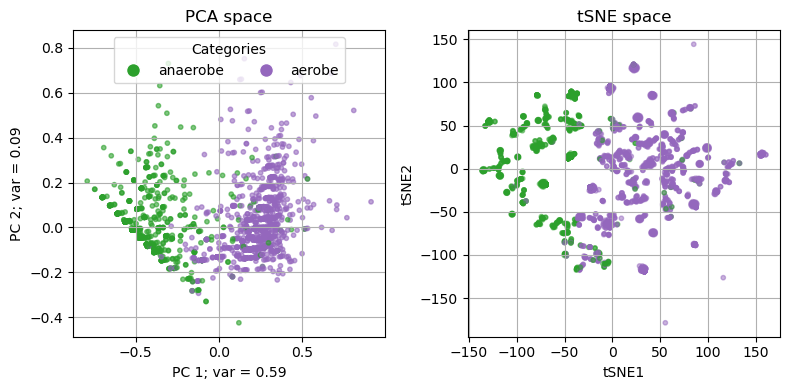

In [14]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()


In [15]:
y_label_train = y_train
y_label_test = y_test

X_val_train, X_val_test = X_train.cpu(), X_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 500
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [16]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.9291973545180605), 'precision': np.float64(0.9344904014758381), 'recall': np.float64(0.9596765440138935), 'f1': np.float64(0.9468491648921228), 'roc_auc': np.float64(0.9180666116188352)}
{'accuracy': 0.9257503949447078, 'precision': np.float64(0.9324618736383442), 'recall': np.float64(0.963963963963964), 'f1': np.float64(0.9479512735326688), 'roc_auc': np.float64(0.9022594022594023)}


In [ ]:
sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(
    X_train.cpu(), 
    y_train.cpu(), 
    X_column_names
)

cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(
    X_val_train.cpu(), X_val_test.cpu(), 
    y_label_train.cpu(), y_label_test.cpu(), 
    sorted_cog_idx_by_mi, 
    feat_step, 
    DEVICE, 
    feat_removal
)       


In [23]:
def xgboost_accur_select_features_rand(
    X_val_train, X_val_test, 
    y_label_train, y_label_test, 
    feat_step, DEVICE, feat_removal,
    n_cols, reps):
    
    idx = list(range(n_cols))

    shuffled_idx_list = []
    cv_accur_arr_rand = []
    test_accur_arr_rand = []

    for i in range(reps):

        #shuffle idx
        shuffled_idx_cur = idx.copy()
        random.Random(i).shuffle(shuffled_idx_cur)
        shuffled_idx_list.append(shuffled_idx_cur)
    
        #train model
        cv_accur_arr_cur, test_accur_arr_cur, num_feat_cur = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), shuffled_idx_cur, feat_step, DEVICE, feat_removal)       

        cv_accur_arr_rand.append(cv_accur_arr_cur)
        test_accur_arr_rand.append(test_accur_arr_cur)
        
    return cv_accur_arr_rand, test_accur_arr_rand, num_feat_cur

In [25]:
cv_accur_arr_rand, test_accur_arr_rand, num_feat_cur = xgboost_accur_select_features_rand(
    X_val_train, X_val_test, 
    y_label_train, y_label_test, 
    feat_step=500, DEVICE=DEVICE, feat_removal=False,
    n_cols=n_cols, reps=5)

In [26]:
def plot_accuracy_metric_rand(metric,
                              test_accur_arr_rand, num_feat_cur,
                              num_feat, n_cols):

    
    #Results
    # metric_name = 'accuracy'
    
    data = test_accur_arr_rand.copy()
    
    results = []
    for i, repetition in enumerate(data):
        for j, metrics in enumerate(repetition):
            results.append({
                'N_features': num_feat_cur[i],#rep
                metric_name: metrics[metric]
            })
    
    df = pd.DataFrame(results)
    
    #Plot plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='N_features', y=metric, errorbar='ci', c='black')
    plt.title(f'Lineplot of {metric} with Confidence Intervals')
    plt.xlabel('Number of Features')
    plt.ylabel(metric.capitalize())
    plt.grid()
    plt.show()
    

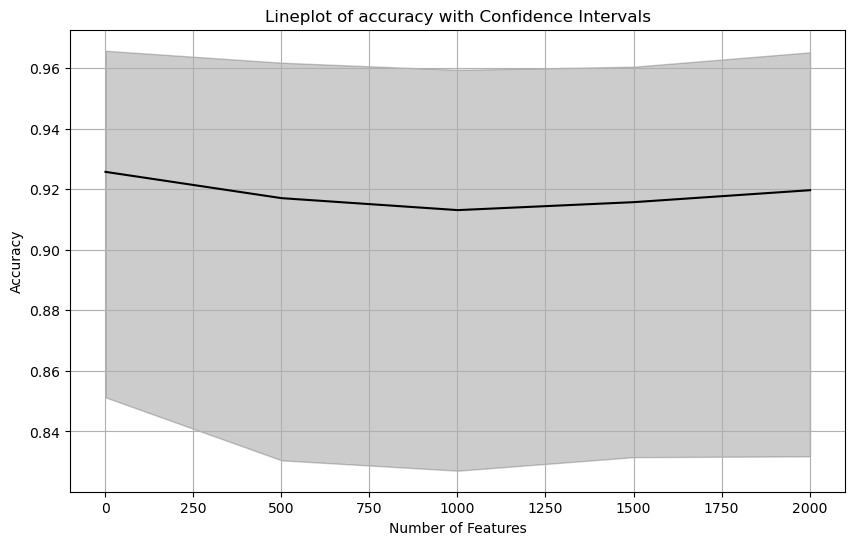

In [27]:
plot_accuracy_metric_rand('accuracy', test_accur_arr_rand, num_feat_cur, num_feat, n_cols)

In [ ]:

    #Results
    metric_name = 'accuracy'
    
    # if feat_removal: 
    #     data = cv_accur_arr_rem_rand.copy()
    # else:
    #     data = cv_accur_arr_rand.copy()
    data = cv_accur_arr_rand.copy()
    
    num_feat_cur_Q = num_feat_cur.copy()
    
    results = []
    for i, repetition in enumerate(data):
        for j, metrics in enumerate(repetition):
            results.append({
                'N_features': num_feat_cur_Q[i],#rep
                metric_name: metrics[metric_name]
            })
    
    df = pd.DataFrame(results)
    
    #Plot plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='N_features', y=metric_name, errorbar='ci', c='black')
    plt.title(f'Lineplot of {metric_name} with Confidence Intervals')
    plt.xlabel('Number of Features')
    plt.ylabel(metric_name.capitalize())
    plt.grid()
    plt.show()

In [ ]:
#Random 
#reps, list_of_column names
#shuffle, train, create results

def add_random_plots(n_cols, reps = 5, feat_step = 50, feat_removal = False)


idx = list(range(n_cols))

shuffled_idx_list = []

cv_accur_arr_rand = []
test_accur_arr_rand = []
# num_feat_rand = []# NENAD

# cv_accur_arr_rem_rand = []
# test_accur_arr_rem_rand = []
# num_feat_rem_rand = []# NENAD

for i in range(reps):

    #shuffle idx
    shuffled_idx_cur = idx.copy()
    random.Random(i).shuffle(shuffled_idx_cur)
    shuffled_idx_list.append(shuffled_idx_cur)

    #train model
    # feat_step = 50
    # feat_removal = False
    cv_accur_arr_cur, test_accur_arr_cur, num_feat_cur = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), shuffled_idx_cur, feat_step, DEVICE, feat_removal)       
    
    # feat_removal = True
    # cv_accur_arr_rem_cur, test_accur_arr_rem_cur, num_feat_rem_cur = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), shuffled_idx_cur, feat_step, DEVICE, feat_removal)       

    cv_accur_arr_rand.append(cv_accur_arr_cur)
    test_accur_arr_rand.append(test_accur_arr_cur)
    num_feat_rand.append(num_feat_cur)# NENAD
    
    # cv_accur_arr_rem_rand.append(cv_accur_arr_rem_cur)
    # test_accur_arr_rem_rand.append(test_accur_arr_rem_cur)
    # num_feat_rem_rand.append(num_feat_rem_cur)# NENAD

#Results
metric_name = 'accuracy'

# if feat_removal: 
#     data = cv_accur_arr_rem_rand.copy()
# else:
#     data = cv_accur_arr_rand.copy()
data = cv_accur_arr_rand.copy()

num_feat_cur_Q = num_feat_cur.copy()

results = []
for i, repetition in enumerate(data):
    for j, metrics in enumerate(repetition):
        results.append({
            'N_features': num_feat_cur_Q[i],#rep
            metric_name: metrics[metric_name]
        })

df = pd.DataFrame(results)

#Plot plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N_features', y=metric_name, errorbar='ci', c='black')
plt.title(f'Lineplot of {metric_name} with Confidence Intervals')
plt.xlabel('Number of Features')
plt.ylabel(metric_name.capitalize())
plt.grid()
plt.show()

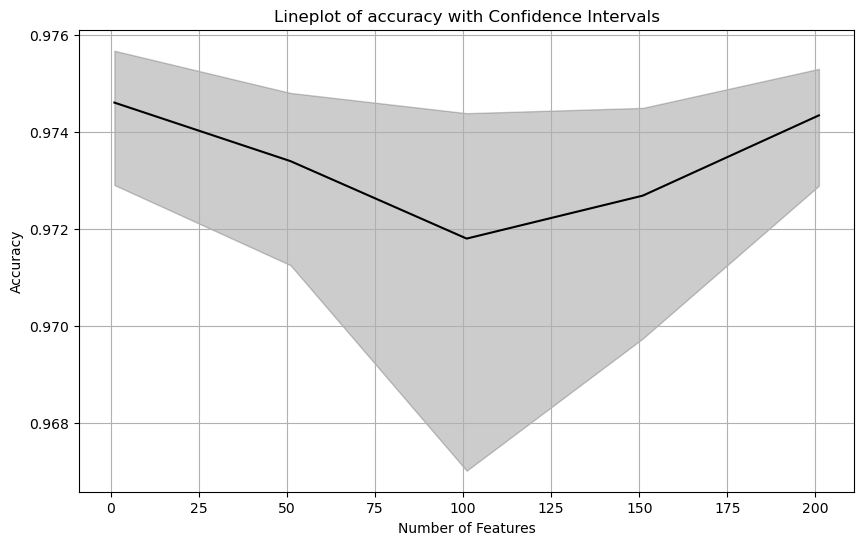

In [20]:
#Random 
#reps, list_of_column names
#shuffle, train, create results



reps = 5
idx = list(range(n_cols))
feat_removal = False

shuffled_idx_list = []

cv_accur_arr_rand = []
test_accur_arr_rand = []
num_feat_rand = []# NENAD

cv_accur_arr_rem_rand = []
test_accur_arr_rem_rand = []
num_feat_rem_rand = []# NENAD

for i in range(reps):

    #shuffle idx
    shuffled_idx_cur = idx.copy()
    random.Random(i).shuffle(shuffled_idx_cur)
    shuffled_idx_list.append(shuffled_idx_cur)

    #train model
    feat_step = 50
    feat_removal = False
    cv_accur_arr_cur, test_accur_arr_cur, num_feat_cur = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), shuffled_idx_cur, feat_step, DEVICE, feat_removal)       
    
    feat_removal = True
    cv_accur_arr_rem_cur, test_accur_arr_rem_cur, num_feat_rem_cur = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), shuffled_idx_cur, feat_step, DEVICE, feat_removal)       

    cv_accur_arr_rand.append(cv_accur_arr_cur)
    test_accur_arr_rand.append(test_accur_arr_cur)
    num_feat_rand.append(num_feat_cur)# NENAD
    
    cv_accur_arr_rem_rand.append(cv_accur_arr_rem_cur)
    test_accur_arr_rem_rand.append(test_accur_arr_rem_cur)
    num_feat_rem_rand.append(num_feat_rem_cur)# NENAD

#Results
metric_name = 'accuracy'

if feat_removal: 
    data = cv_accur_arr_rem_rand.copy()
else:
    data = cv_accur_arr_rand.copy()
num_feat_cur_Q = num_feat_cur.copy()

results = []
for i, repetition in enumerate(data):
    for j, metrics in enumerate(repetition):
        results.append({
            'N_features': num_feat_cur_Q[i],#rep
            metric_name: metrics[metric_name]
        })

df = pd.DataFrame(results)

#Plot plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N_features', y=metric_name, errorbar='ci', c='black')
plt.title(f'Lineplot of {metric_name} with Confidence Intervals')
plt.xlabel('Number of Features')
plt.ylabel(metric_name.capitalize())
plt.grid()
plt.show()

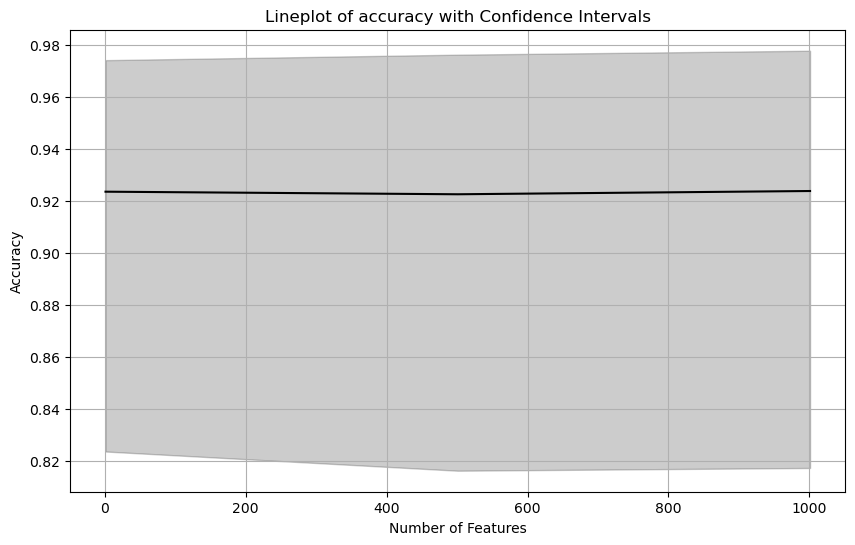

In [63]:
data = cv_accur_arr_rand.copy()
num_feat_cur_Q = num_feat_cur.copy()

metric_name = 'accuracy'

# Подготовка данных для DataFrame
results = []
for i, repetition in enumerate(data):
    # print(i, repetition)
    for j, metrics in enumerate(repetition):
        # print(i, j)
        # print(i, j, metrics)
        results.append({
            'N_features': num_feat_cur_Q[i],#rep
            metric_name: metrics[metric_name]
        })
        # print(num_feat_cur_Q[i])
        # print(metrics[metric_name])

results

df = pd.DataFrame(results)
df

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N_features', y=metric_name, errorbar='ci', c='black')
plt.title(f'Lineplot of {metric_name} with Confidence Intervals')
plt.xlabel('Number of Features')
plt.ylabel(metric_name.capitalize())
plt.grid()
plt.show()

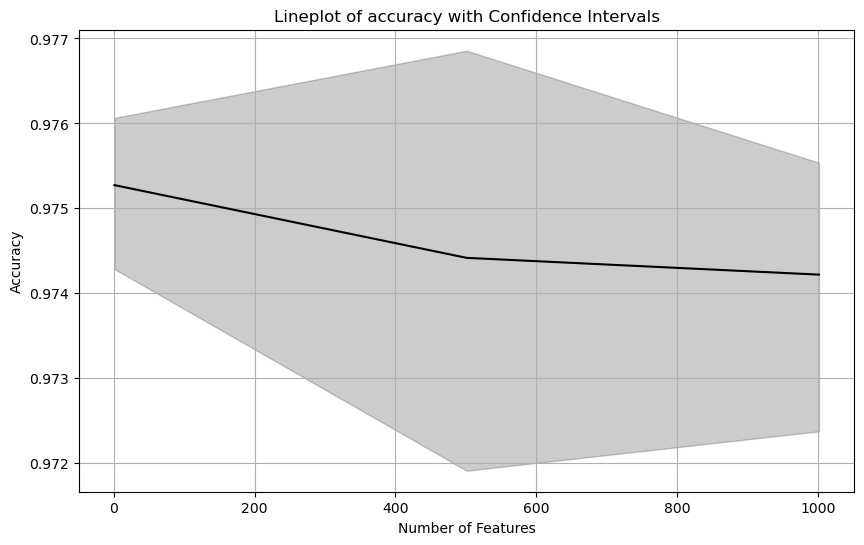

In [64]:
data = cv_accur_arr_rem_rand.copy()
num_feat_cur_Q = num_feat_cur.copy()

metric_name = 'accuracy'

# Подготовка данных для DataFrame
results = []
for i, repetition in enumerate(data):
    # print(i, repetition)
    for j, metrics in enumerate(repetition):
        # print(i, j)
        # print(i, j, metrics)
        results.append({
            'N_features': num_feat_cur_Q[i],#rep
            metric_name: metrics[metric_name]
        })
        # print(num_feat_cur_Q[i])
        # print(metrics[metric_name])

results

df = pd.DataFrame(results)
df

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N_features', y=metric_name, errorbar='ci', c='black')
plt.title(f'Lineplot of {metric_name} with Confidence Intervals')
plt.xlabel('Number of Features')
plt.ylabel(metric_name.capitalize())
plt.grid()
plt.show()

In [49]:
data = cv_accur_arr_rand.copy()
num_feat_cur_Q = num_feat_cur.copy()

metric_name = 'accuracy'



In [59]:
# Подготовка данных для DataFrame
results = []
for i, repetition in enumerate(data):
    # print(i, repetition)
    for j, metrics in enumerate(repetition):
        print(i, j)
        # print(i, j, metrics)
        results.append({
            'N_features': num_feat_cur_Q[i],#rep
            metric_name: metrics[metric_name]
        })
        # print(num_feat_cur_Q[i])
        # print(metrics[metric_name])

results

df = pd.DataFrame(results)
df

0 0
0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5


,N_features,accuracy
0,1,0.673670
1,1,0.971123
2,1,0.973893
3,1,0.973494
4,1,0.973889
5,1,0.975075
6,501,0.657437
7,501,0.973493
8,501,0.976656
9,501,0.976261


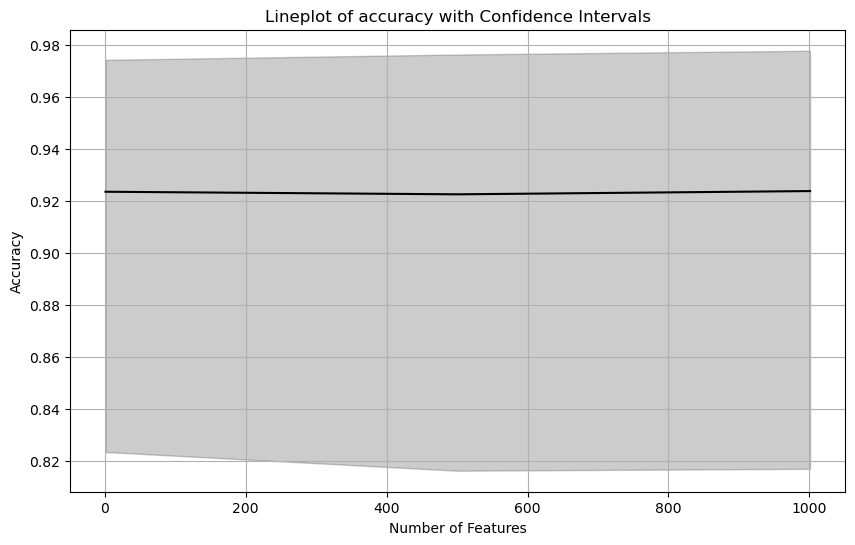

In [60]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N_features', y=metric_name, errorbar='ci', c='black')
plt.title(f'Lineplot of {metric_name} with Confidence Intervals')
plt.xlabel('Number of Features')
plt.ylabel(metric_name.capitalize())
plt.grid()
plt.show()

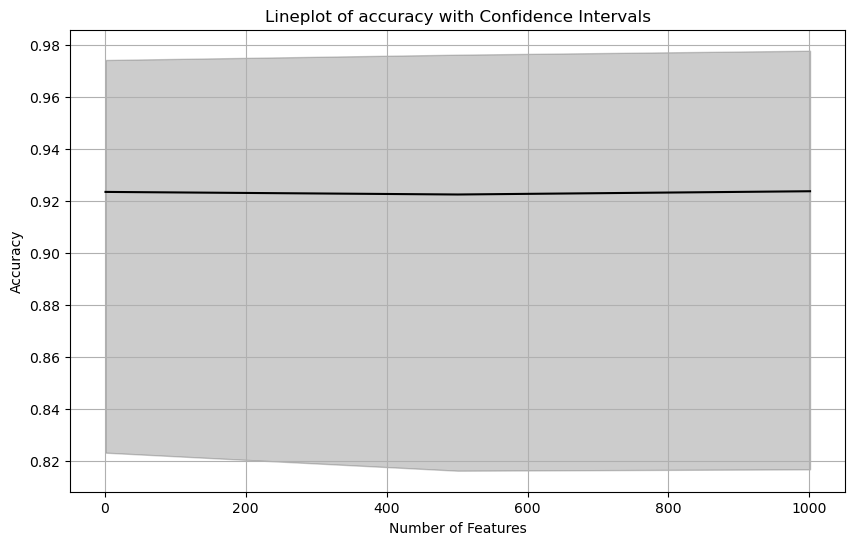

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных
# data = [
#     [{'accuracy': 0.7424960505529226, 'precision': np.float64(0.7676190476190476), 'recall': np.float64(0.9076576576576577)},
#      {'accuracy': 0.9620853080568721, 'precision': np.float64(0.9565217391304348), 'recall': np.float64(0.990990990990991)},
#      {'accuracy': 0.9510268562401264, 'precision': np.float64(0.9538461538461539), 'recall': np.float64(0.9774774774774775)},
#      {'accuracy': 0.9699842022116903, 'precision': np.float64(0.9753914988814317), 'recall': np.float64(0.9819819819819819)},
#      {'accuracy': 0.9652448657187994, 'precision': np.float64(0.9668141592920354), 'recall': np.float64(0.9842342342342343)},
#      {'accuracy': 0.9636650868878357, 'precision': np.float64(0.9646799116997793), 'recall': np.float64(0.9842342342342343)}],
#     [{'accuracy': 0.7014218009478673, 'precision': np.float64(0.7014218009478673), 'recall': np.float64(1.0)},
#      {'accuracy': 0.7500000000000001, 'precision': np.float64(0.7500000000000001), 'recall': np.float64(1.0)},
#      {'accuracy': 0.8000000000000002, 'precision': np.float64(0.8000000000000002), 'recall': np.float64(1.0)}]
# ]

data = cv_accur_arr_rand.copy()

num_feat_cur_Q = num_feat_cur.copy()#[5, 10]  # Пример значений для оси x

# Задаем метрику для анализа
metric_name = 'accuracy'

# Подготовка данных для DataFrame
results = []
for i, repetition in enumerate(data):
    for j, metrics in enumerate(repetition):
        results.append({
            'N_features': num_feat_cur_Q[i],  # Индекс повторения соответствует индексу num_feat_cur
            metric_name: metrics[metric_name]
        })

df = pd.DataFrame(results)

# Построение графика
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='N_features', y=metric_name, errorbar='ci', c='black')
plt.title(f'Lineplot of {metric_name} with Confidence Intervals')
plt.xlabel('Number of Features')
plt.ylabel(metric_name.capitalize())
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_analyze):
    plt.subplot(3, 3, i + 1)

    sns.lineplot(data=df, x="N_features", y=col, errorbar="ci", c='black')
    
    plt.title(col)
    plt.xlabel('N_features')
    plt.ylabel(col)
    plt.xticks()
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
sns.lineplot(x=num_feat_cur, y=col, errorbar="ci", c='black')

In [41]:
num_feat_cur

[1, 501, 1001, 1501, 2001, 2501]

In [44]:
test_accur_arr_rand

[[{'accuracy': 0.7424960505529226,
   'precision': np.float64(0.7676190476190476),
   'recall': np.float64(0.9076576576576577),
   'f1': np.float64(0.8317853457172343),
   'roc_auc': np.float64(0.6285750035750036)},
  {'accuracy': 0.9620853080568721,
   'precision': np.float64(0.9565217391304348),
   'recall': np.float64(0.990990990990991),
   'f1': np.float64(0.9734513274336283),
   'roc_auc': np.float64(0.9883752800419467)},
  {'accuracy': 0.9510268562401264,
   'precision': np.float64(0.9538461538461539),
   'recall': np.float64(0.9774774774774775),
   'f1': np.float64(0.9655172413793104),
   'roc_auc': np.float64(0.9884169884169884)},
  {'accuracy': 0.9699842022116903,
   'precision': np.float64(0.9753914988814317),
   'recall': np.float64(0.9819819819819819),
   'f1': np.float64(0.978675645342312),
   'roc_auc': np.float64(0.9883812383812384)},
  {'accuracy': 0.9652448657187994,
   'precision': np.float64(0.9668141592920354),
   'recall': np.float64(0.9842342342342343),
   'f1': n

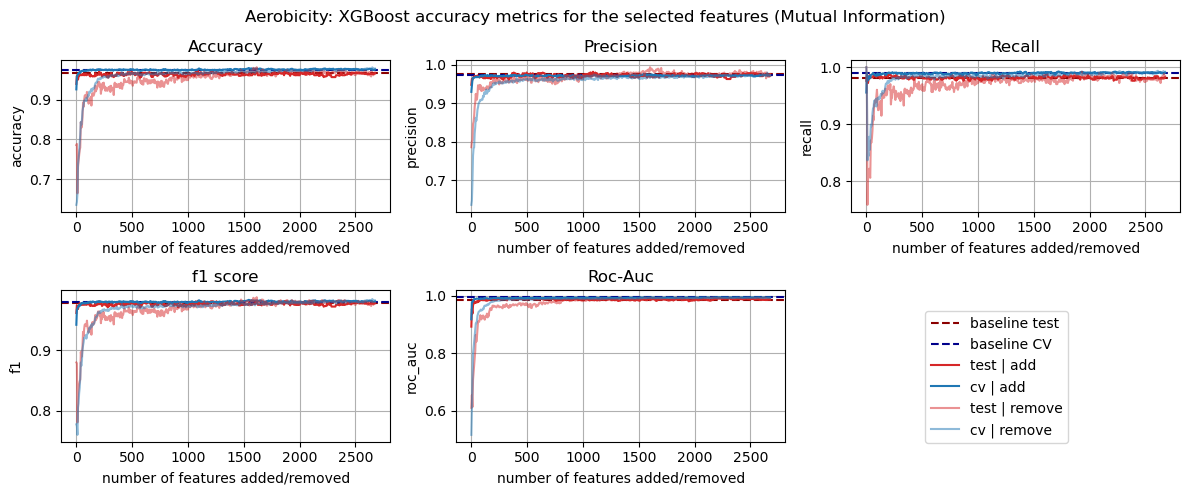

In [18]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Mutual Information)");

### 3.2 Feature selection with Random Forest

In [19]:
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

Original feature count: 2677, Selected feature count: 288


In [20]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG0369', 'COG0026', 'COG1328', 'COG1592', 'COG0109', 'COG0567', 'COG0276', 'COG0320', 'COG0543', 'COG0508']


In [21]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (2517, 5)
Explained variance ratio: [0.57845446 0.09266789 0.0753604  0.05312839 0.04728701]
Total explained variance: 0.8468981513040585
Shape of the projected data = (2517, 2)


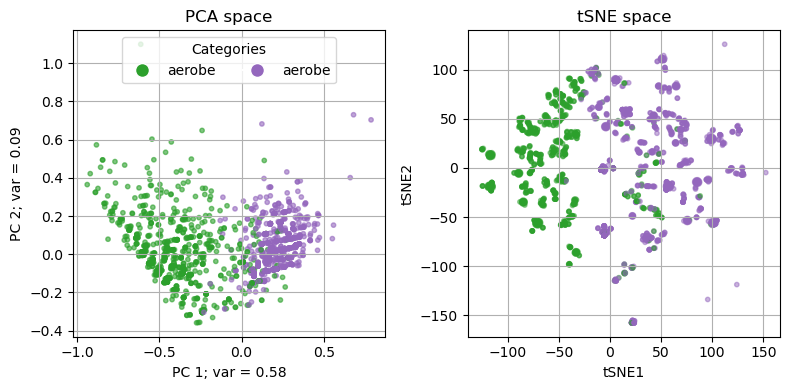

In [22]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [23]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [24]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.8478454668812521), 'precision': np.float64(0.8622086102880624), 'recall': np.float64(0.90625), 'f1': np.float64(0.883451085728708), 'roc_auc': np.float64(0.8333895744238535)}
{'accuracy': 0.8664596273291926, 'precision': np.float64(0.9038461538461539), 'recall': np.float64(0.9288537549407114), 'f1': np.float64(0.9161793372319688), 'roc_auc': np.float64(0.7873918771839378)}


Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)')

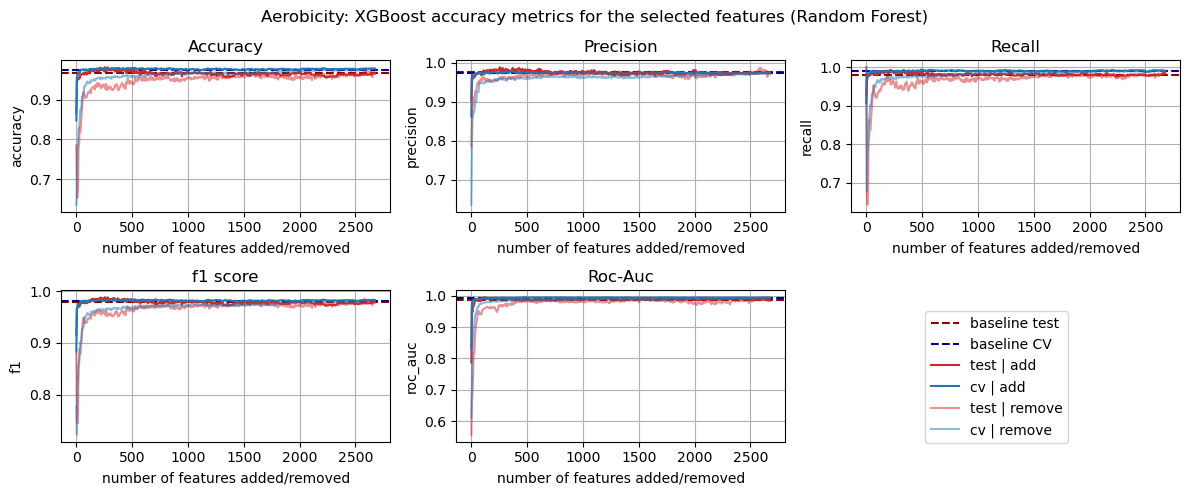

In [25]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)")

### 3.3 SHAP values

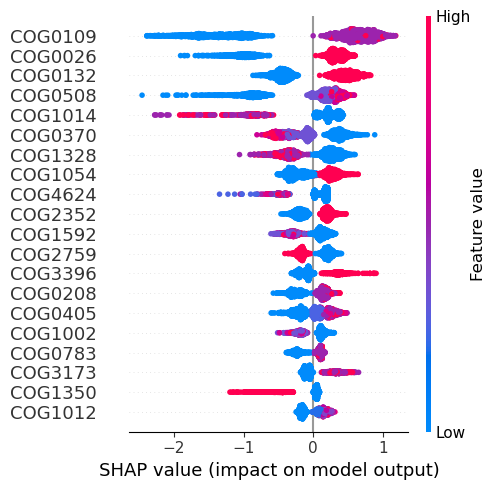

In [30]:
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, DEVICE) 

In [31]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0109', 'COG0026', 'COG0132', 'COG0508', 'COG1014', 'COG0370', 'COG1328', 'COG1054', 'COG4624', 'COG2352']


Data after PCA reduction: (2517, 5)
Explained variance ratio: [0.42819049 0.19270436 0.10519487 0.07433185 0.05750431]
Total explained variance: 0.8579258807425492
Shape of the projected data = (2517, 2)


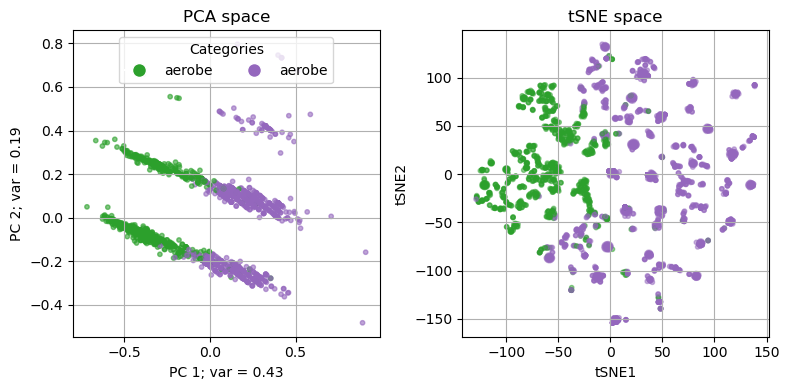

In [32]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']

pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [33]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)')

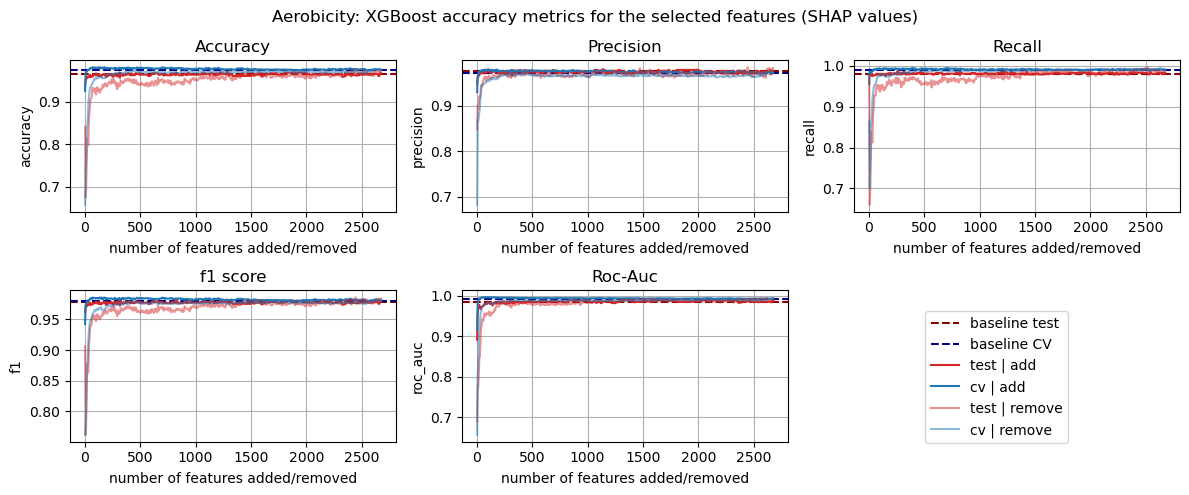

In [34]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)")

## 4. Feature comparison

In [88]:
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

df = pd.DataFrame(data)

df

,MI,RandomForest,SHAP
0,COG0109,COG0369,COG0109
1,COG1592,COG0026,COG0026
2,COG0026,COG1328,COG0132
3,COG1612,COG1592,COG0508
4,COG0508,COG0109,COG1014
5,COG0065,COG0567,COG0370
6,COG0276,COG0276,COG1328
7,COG0567,COG0320,COG1054
8,COG0843,COG0543,COG4624
9,COG1328,COG0508,COG2352


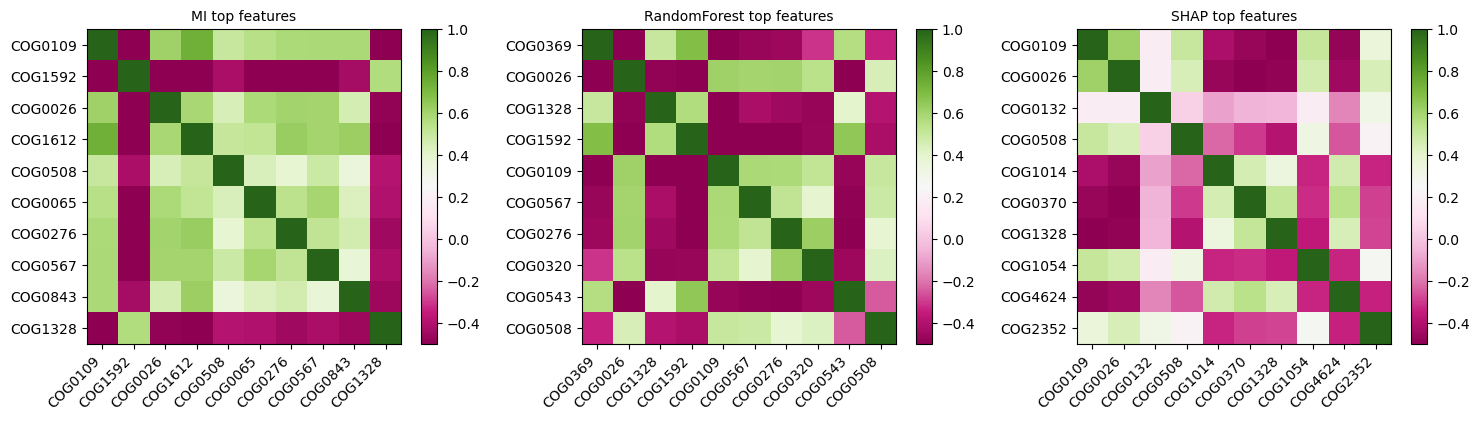

In [36]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.show()

In [100]:
make_cog_descr(df)

,MI,RandomForest,SHAP
0,COG0109: Polyprenyltransferase (heme O synthase),COG0369: Flavoprotein (flavin reductase) subun...,COG0109: Polyprenyltransferase (heme O synthase)
1,COG1592: Rubrerythrin,COG0026: Phosphoribosylaminoimidazole carboxyl...,COG0026: Phosphoribosylaminoimidazole carboxyl...
2,COG0026: Phosphoribosylaminoimidazole carboxyl...,COG1328: Anaerobic ribonucleoside-triphosphate...,COG0132: Dethiobiotin synthetase
3,COG1612: Heme A synthase,COG1592: Rubrerythrin,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...
4,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...,COG0109: Polyprenyltransferase (heme O synthase),COG1014: Pyruvate:ferredoxin oxidoreductase or...
5,COG0065: Homoaconitase/3-isopropylmalate dehyd...,"COG0567: 2-oxoglutarate dehydrogenase complex,...",COG0370: Fe2+ transporter FeoB
6,COG0276: Protoheme ferro-lyase (ferrochelatase),COG0276: Protoheme ferro-lyase (ferrochelatase),COG1328: Anaerobic ribonucleoside-triphosphate...
7,"COG0567: 2-oxoglutarate dehydrogenase complex,...",COG0320: Lipoate synthase,"COG1054: tRNA U34 5'-hydroxylase TrhO, rhodane..."
8,COG0843: Heme/copper-type cytochrome/quinol ox...,COG0543: NAD(P)H-flavin reductase,"COG4624: Iron only hydrogenase large subunit, ..."
9,COG1328: Anaerobic ribonucleoside-triphosphate...,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...,COG2352: Phosphoenolpyruvate carboxylase
